## Chain
 we will build a chain that will combine few core concepts

## Goals
### lets make a simple chain that combines 4 key components
 1. using chat messages in our graph
 2. using chat models
 3. binding tools to our LLM
 4. executing tool calls in our graph

In [1]:
%pip install --quiet langchain_ibm ibm-watson-machine-learning langchain_core

Note: you may need to restart the kernel to use updated packages.


## Messages
### chat models can use "messages" , which captures different roles within a convo(say role might be human , model)
### Langchain supports various message types , including "HumanMessage","AIMessage","SystemMessage", and "ToolMessage"
### These represents a message from the user, chat model,for chat model to instruct behaviour,and from a tool call
### lets create a list of messages , each ,essage can be supplied with few things:
 1. "content"-content of message
 2. "name"-who is creating message(model/human..etc)
 3. "response_metadata"-dict of metadata that is specific to each model provider


In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content=f"So you said you were researching ocean spring framework?", name="Model")]
messages.extend([HumanMessage(content=f"Yes, that's right.", name="jas")])
messages.extend([AIMessage(content=f"Great, what would you like to learn about.", name="Model")])
messages.extend([HumanMessage(content=f"I want to learn about dependency injection and circular dependency in particular", name="jas")])

for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Model

So you said you were researching ocean spring framework?
================================ Human Message =================================
Name: jas

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: jas

I want to learn about dependency injection and circular dependency in particular


## Chat Models

[Chat models](https://platform.openai.com/docs/guides/gpt) can use a sequence of message as input and support message roles, as discussed above.

There are many to choose from!

I am using model from watsonX platform(since i have access) , you can try using any model of your wish



In [4]:
from langchain_ibm import ChatWatsonx, WatsonxLLM
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "LFzc1O7mM0I_Tz2pJmkKjFt-zyYL_U3JLnAjq5MTzay4"
}

project_id = "4af85c47-e2f4-4ffc-af1e-6d8fba82349e"
api_key = credentials.get("apikey")
project_url = credentials.get("url")

### configure LLM

In [5]:
llm = ChatWatsonx(
    model_id="ibm/granite-3-2-8b-instruct", 
    url=credentials.get("url"),
    apikey=credentials.get("apikey"),
    project_id=project_id,
    params={
        GenParams.DECODING_METHOD: "sample",
        GenParams.TEMPERATURE: 0.7
    },
)

In [6]:
result=llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

### We gave chat messages , now our chat model goes through this chat message conversation depending on role and answer the user query with help of context from messages

In [8]:
pprint(result)

AIMessage(content="Sure, I'd be happy to explain these concepts in the context of Ocean Spring Framework.\n\n1. **Dependency Injection (DI):**\n\nDependency Injection is a design pattern that allows us to eliminate hard-coded dependencies and make our applications loosely coupled, extendable, and maintainable. In Ocean Spring Framework, DI is achieved using the `@Inject` annotation.\n\nHere's a simple example:\n\n```java\npublic class ServiceA {\n    private final ServiceB serviceB;\n\n    @Inject\n    public ServiceA(ServiceB serviceB) {\n        this.serviceB = serviceB;\n    }\n\n    // ...\n}\n\npublic class ServiceB {\n    // ...\n}\n```\n\nIn this example, `ServiceA` depends on `ServiceB`. Instead of creating an instance of `ServiceB` within `ServiceA`, we inject it through its constructor. This way, we can easily swap implementations of `ServiceB` without changing the code in `ServiceA`.\n\n2. **Circular Dependency:**\n\nCircular dependency occurs when two or more classes depend

In [9]:
result.response_metadata

{'token_usage': {'completion_tokens': 644,
  'prompt_tokens': 115,
  'total_tokens': 759},
 'model_name': 'ibm/granite-3-2-8b-instruct',
 'system_fingerprint': '',
 'finish_reason': 'stop'}

## Tools
### In simple terms , Tools are python functions binded with agents , which are called by agents , if reasoning process demands to , in order to get the best output for the user prompt

Lets define a simple function that returns multiplication of 2 numbers when 2 numbers are passed as parameters

In [10]:
def multiply(a:int , b:int):
    return a*b

### Let's bind multiply tool with llm which we configured above

In [11]:
llm_with_tools=llm.bind_tools([multiply])

Let's query llm and see if it uses available tool

In [12]:
tool_call=llm_with_tools.invoke([HumanMessage(content="what is 2 multiplied by 3",name="jas")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-7a7e4ed09e454f37ae5e1f76563c355f', 'type': 'function', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 230, 'total_tokens': 257}, 'model_name': 'ibm/granite-3-2-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-4bf7339be529a9bd5f12c0512f158fe4', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'chatcmpl-tool-7a7e4ed09e454f37ae5e1f76563c355f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 230, 'output_tokens': 27, 'total_tokens': 257})

### Using messages as graph state

 1. lets define our state MessageState
 2. lets keep messages as list of messages

In [15]:
from typing import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages:list[AnyMessage]

# Reducers

Now, we have a minor problem!

As our graph runs, we want to append messages to our `messages` state key.

But, as we discussed, each node [will also override](#) the prior state value.

[Reducer functions](#) address this.

They allow us to specify how state updates are performed.

If no reducer function is explicitly specified, then it is assumed that all updates to that key should *override it*.

Since we want to append messages, we can use a pre-built `add_messages` reducer!

This ensures that state updates you send to the graph are appended to the existing list of messages.

We annotate (via `Annotated`) our key with a reducer function as metadata.


In [16]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### OUR graph
lets use MessageState that we defined above with a graph

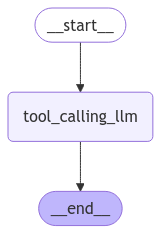

In [18]:
from IPython.display import Image , display
from langgraph.graph import START,END,StateGraph

class MessagesState(MessagesState):
    pass

#Node
def tool_calling_LLM(state:MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder=StateGraph(MessagesState)
builder.add_node("tool_calling_llm",tool_calling_LLM)
builder.add_edge(START,"tool_calling_llm")
builder.add_edge("tool_calling_llm",END)
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages=graph.invoke({"messages":HumanMessage(content="hello!")})
messages

{'messages': [HumanMessage(content='hello!', additional_kwargs={}, response_metadata={}, id='83b1564f-674e-4c91-a069-b199a81b1a91'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 223, 'total_tokens': 233}, 'model_name': 'ibm/granite-3-2-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'}, id='chatcmpl-e3c397edd3e5e795761be9521764f8fc', usage_metadata={'input_tokens': 223, 'output_tokens': 10, 'total_tokens': 233})]}

### observe that our LLM responded without using any tool

### Now lets give a human message , will see if LLM uses tool or no

In [20]:
messages=graph.invoke({"messages":HumanMessage(content="what is answer when 2 is multiplied by 3?")})
messages

{'messages': [HumanMessage(content='what is answer when 2 is multiplied by 3?', additional_kwargs={}, response_metadata={}, id='5d175714-e822-4032-8d37-f71fac3756b6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-d1ff90332c41415ca26d32eaeb648248', 'type': 'function', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 234, 'total_tokens': 261}, 'model_name': 'ibm/granite-3-2-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-dc794d20d3135bb03d315c8c351b6c39', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'chatcmpl-tool-d1ff90332c41415ca26d32eaeb648248', 'type': 'tool_call'}], usage_metadata={'input_tokens': 234, 'output_tokens': 27, 'total_tokens': 261})]}

### It can be seen in AIMessage that it made a tool call named "multiply"
## yayy!

In [21]:
messages=graph.invoke({"messages" : HumanMessage(content="how are you!")})
messages

{'messages': [HumanMessage(content='how are you!', additional_kwargs={}, response_metadata={}, id='c9e26150-483b-4632-97d0-9388c3b5e693'),
  AIMessage(content="I'm an artificial intelligence, so I don't have feelings, but I'm here and ready to assist you! How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 225, 'total_tokens': 259}, 'model_name': 'ibm/granite-3-2-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'}, id='chatcmpl-3a927f4aaf2bba4619169b2396bd9592', usage_metadata={'input_tokens': 225, 'output_tokens': 34, 'total_tokens': 259})]}

### our LLM now not using tool!